# Head Velocity
Notebook for clean attempt of checking the distribution of head velocit and stimulus related behavior of the animal.

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'
dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions').set_index('index')

In [2]:
# in use functions
def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta


def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    df['theta0'] = np.arccos(angle_cos(V1,V2))
    return df


def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


## Angular velocity calculations
Calculating vectors, angle, velocity for comparison.

In [3]:
pd.options.mode.chained_assignment = None 

## SMOOTHING THE DATA
windowsize = 200
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

dfV = dfrat.copy()
g = dfV.groupby('session_id')
dfV[colChoice] = g[colChoice].rolling(window=windowsize).mean().values

dfV.dropna(inplace=True)


In [4]:
ori_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


ori_lSM = dfV.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


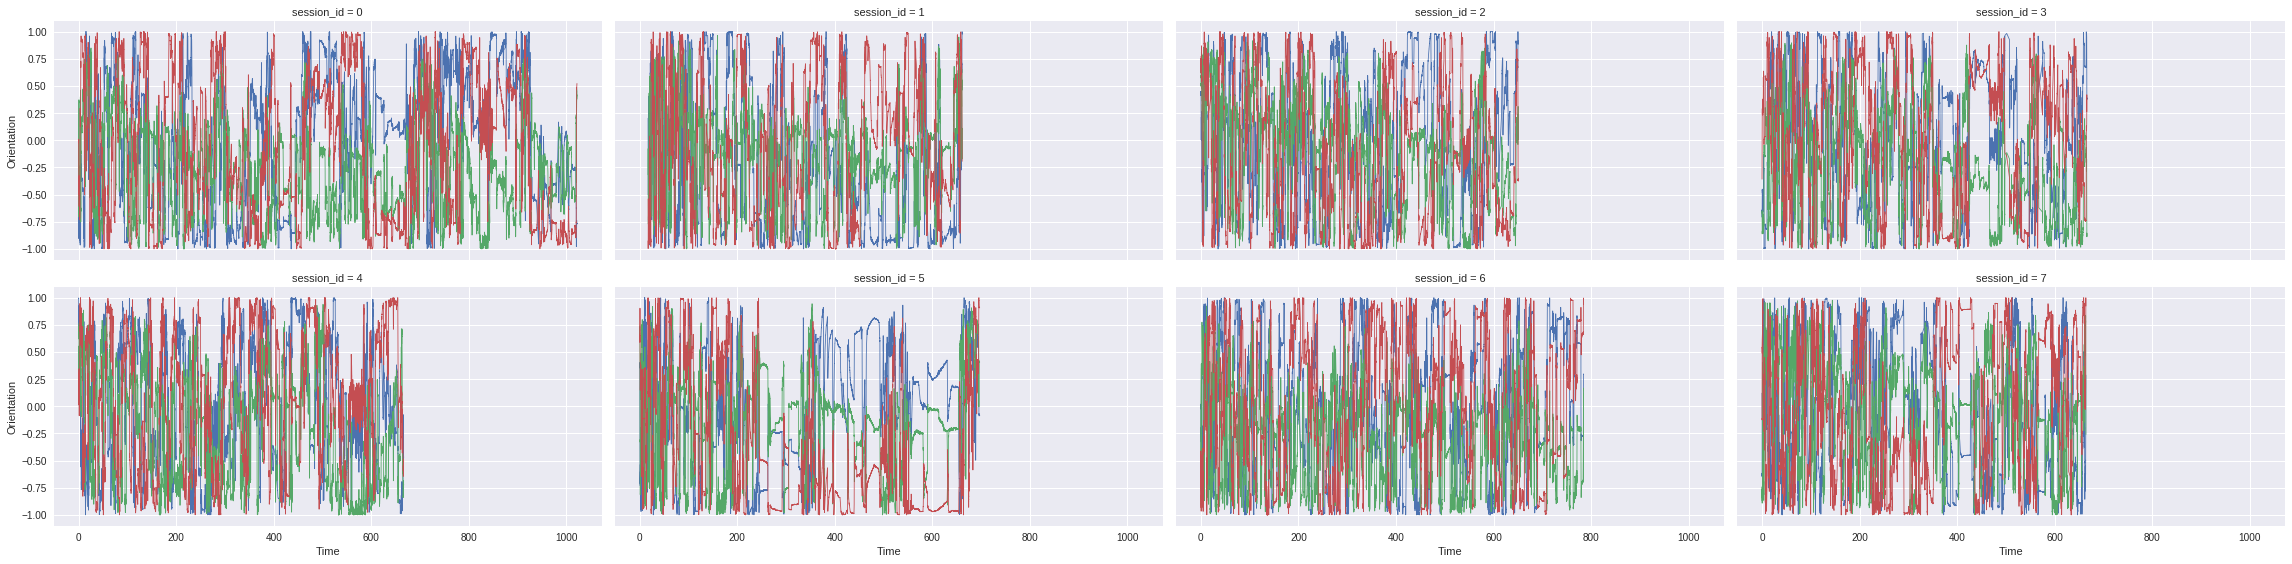

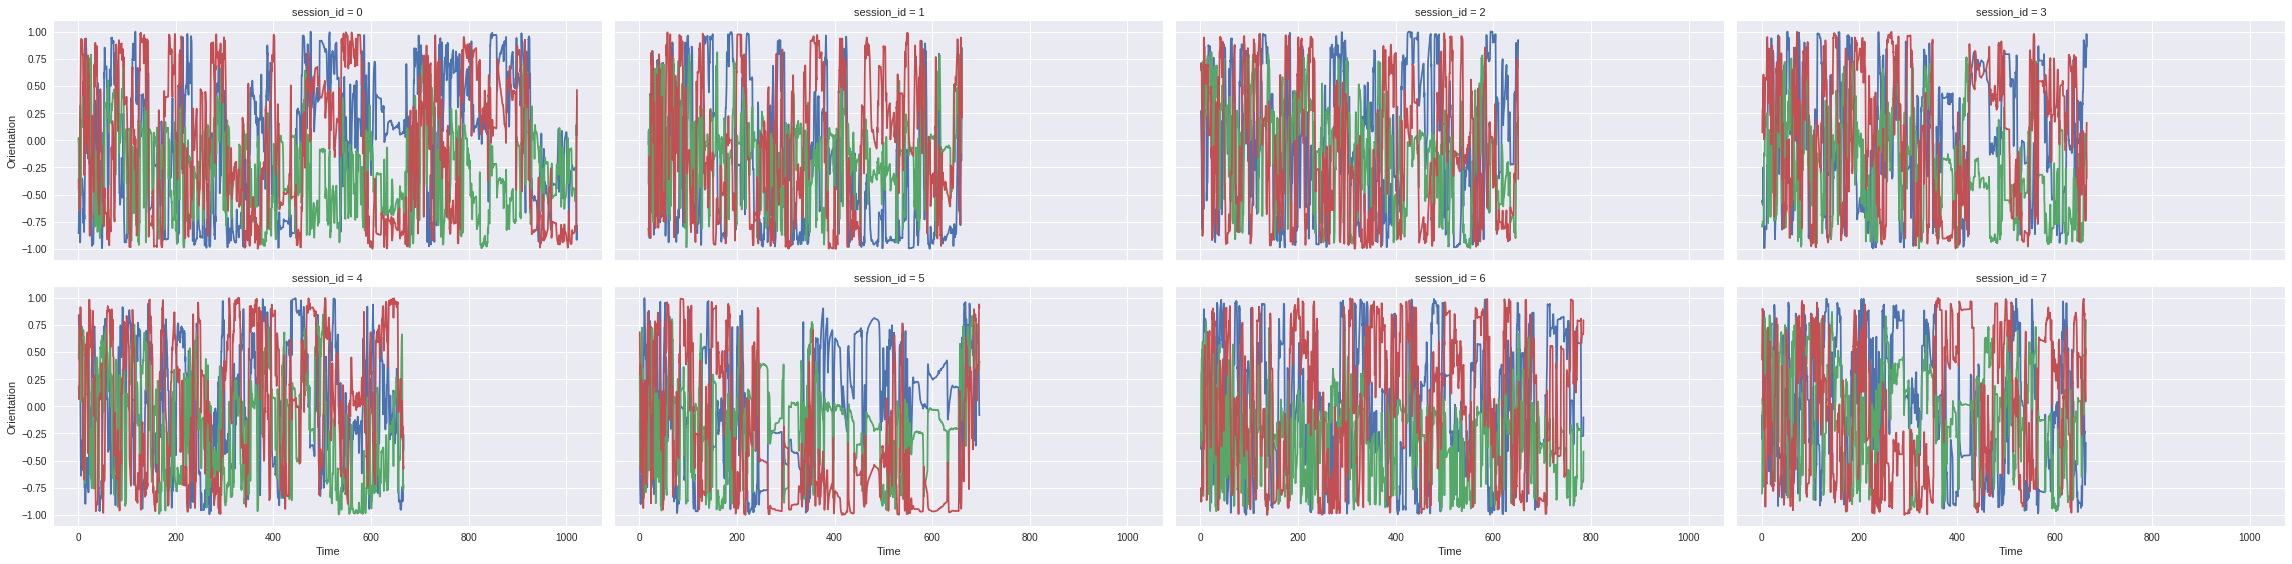

In [5]:
# plotting orientation before and after smoothing
g = sns.FacetGrid(col='session_id', hue='Dimension', data=ori_l, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Orientation", alpha=1, linewidth=0.8);

g = sns.FacetGrid(col='session_id', hue='Dimension', data=ori_lSM, size=4, aspect=2, col_wrap=4)
g.map(plt.plot, "Time", "Orientation", alpha=1);


In [6]:
## VECTORS WITHOUT Y
dfOri = pd.DataFrame()

for name, dd in dfV.groupby('session_id'):
    print(name)
    dd['dT'] = dd['Time'].diff(1)
    
    # calculating lenghts of VecX and VecZ and creation of shifted vectors  #dd = dd.apply(decompose_vec_df, axis=1)
    dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
    dd['lx1'] = dd['X_Ori'] / dd['lVo']
    dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
    # normalize the data to unit vector form
    dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
    dd['lx1'] = dd.lx1 / dd.V1
    dd['lz1'] = dd.lz1 / dd.V1

    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()
# print(dfOri)

0
1
2
3
4
5
6
7


In [7]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    print(name)
    
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V2 = np.array([1     , 0, 0     ])
    
#     dd['theta0'] = np.arccos(dd.lx1*1 + dd.lz1*0 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    dd['theta0'] = np.arccos(dd.lx1 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    
    dd['theta1'] = dd.theta0.shift(1)
    dd['theta']  = dd.theta0 - dd.theta1
    dd.drop({'theta0','theta1'}, axis=1, inplace=True)
    
    # angular velocity between two vectors
    dd['U'] = np.degrees(dd.theta)/ dd.dT
    dd['UMK'] = dd['U'].rolling(window=1000).mean()
    dd['UM'] = dd['U'].rolling(window=200).mean()
    
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)
    
dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()
dfOri2 = dfOri2[np.absolute(dfOri2['dT'])<0.005]

# print(len(dfOri2[np.absolute(dfOri2['dT'])>0.005]))
# print(dfOri2.dT)


0
1
2
3
4
5
6
7


In [10]:
import sys 
sys.getsizeof(dfOri2)/1024**2

183.53733825683594

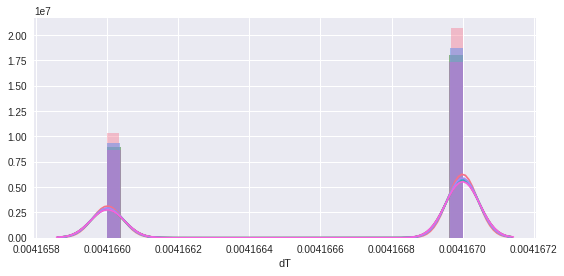

In [8]:
# dfOri2 = dfOri2[np.absolute(dfOri2['U']) < 100]
# pd.set_option('display.max_rows', 4000)

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');


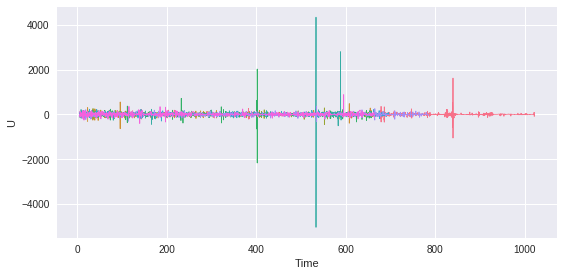

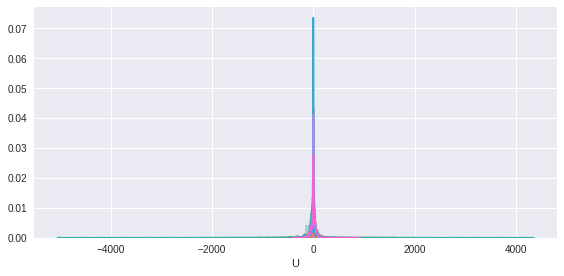

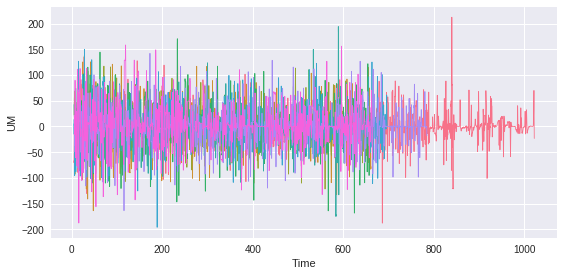

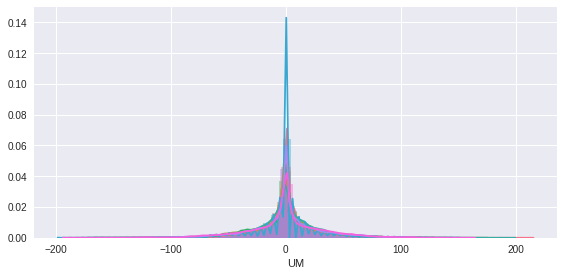

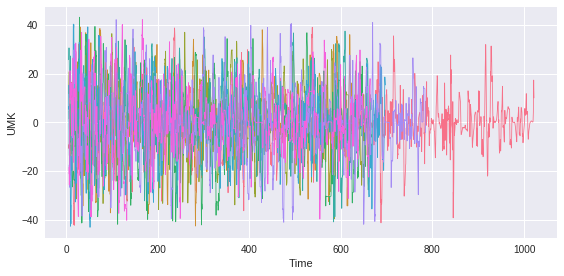

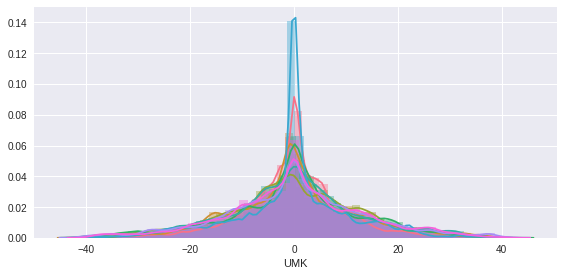

In [12]:
## ANGULAR VELOCITY IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'UM');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "UMK", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'UMK');


# dfOri2[np.absolute(dfOri2['U']) > 100]


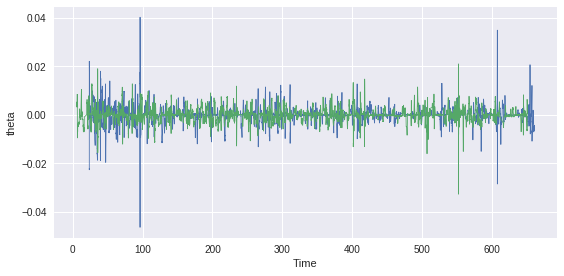

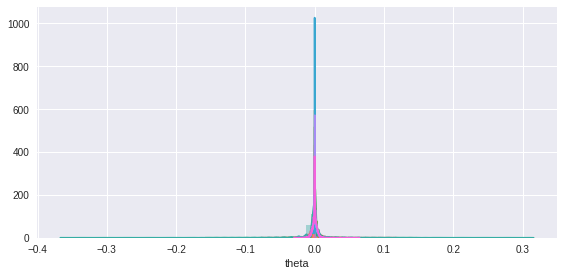

In [10]:
## THETHA CHANGE IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "theta", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'theta');


## Stimulus-related behavior
Looking for frames detected as SRB.

SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax}

In [ ]:
# ## COMPARISON WITH EVENT DATA
dfOri3 = pd.DataFrame()
DmaxPerc = 0.2

dfeventsClean = dfevent.drop({'MotiveExpTimeSecs', 'session_id','Time'}, axis=1)
dfV = pd.merge(dfOri2, dfeventsClean, on='Frame')

dfV.head()


,Frame,Time,X_Pos,Y_Pos,Z_Pos,session_id,X_Ori,Y_Ori,Z_Ori,dT,lVo,lx1,lz1,V1,theta,U,UMK,UM,visible,speed
0,1200,5.0,-0.063064,0.076323,0.036145,0,-0.332573,-0.506422,0.732668,0.004166,477.05412,-0.413331,0.910581,0.001687,-0.005187,-71.338871,-10.264979,-66.863851,0,0.0
1,1200,5.0,-0.063064,0.076323,0.036145,0,-0.332573,-0.506422,0.732668,0.004166,477.05412,-0.413331,0.910581,0.001687,-0.005187,-71.338871,-10.264979,-66.863851,0,0.0
2,1200,5.0,-0.063064,0.076323,0.036145,0,-0.332573,-0.506422,0.732668,0.004166,477.05412,-0.413331,0.910581,0.001687,-0.005187,-71.338871,-10.264979,-66.863851,1,0.0
3,1200,5.0,-0.063064,0.076323,0.036145,0,-0.332573,-0.506422,0.732668,0.004166,477.05412,-0.413331,0.910581,0.001687,-0.005187,-71.338871,-10.264979,-66.863851,0,0.0
4,1200,5.0,-0.063064,0.076323,0.036145,0,-0.332573,-0.506422,0.732668,0.004166,477.05412,-0.413331,0.910581,0.001687,-0.005187,-71.338871,-10.264979,-66.863851,0,0.0


In [ ]:
dfV['subUM']  = dfV['speed'] - dfV['UM'] 
dfV['subU']   = dfV['speed'] - dfV['U'] 
dfV['subUMK'] = dfV['speed'] - dfV['UMK'] 
    
dfV = dfV.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
## ANGULAR VELOCITY IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subU');

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUM');

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUMK", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUMK');



In [ ]:
# setting Dmax as 20% of velocity at given moment // what about 0
#     dd['Dmax'] = dd.speed * DmaxPerc
#     dd['Dmax'] = dd.apply(lambda row: 0.1 if row.Dmax == 0 else row.Dmax, axis=1)
#     dd['SRB']  = np.absolute(dd['sub'].values) < np.absolute(dd['Dmax'].values)

